In [4]:
import pandas as pd
import numpy as np

from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = (18.0, 10.0)
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from tqdm import tqdm

In [9]:
dataset = pd.read_csv('../data/processed/train_86400000000000.csv', parse_dates=[1])
# dataset = dataset.loc[dataset['SiteId'] == 1, :]
dataset.shape

(52830, 69)

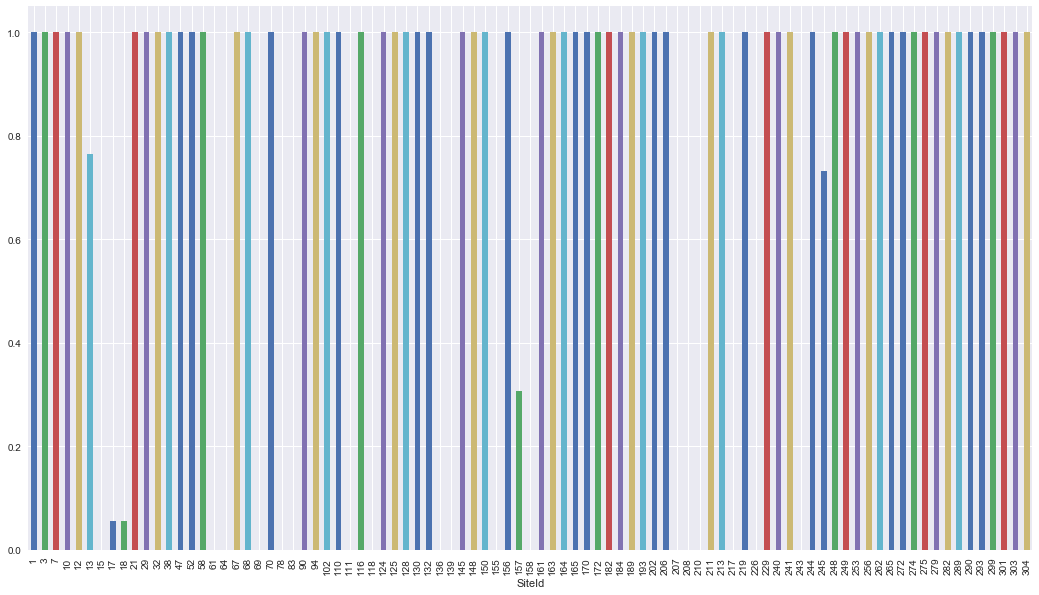

In [10]:
(dataset.groupby('SiteId')['HasTemperature'].sum()/dataset.groupby('SiteId')['HasTemperature'].count()).plot(kind='bar')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a16741eb8>,
      dtype=object)

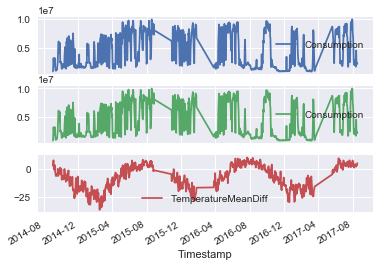

In [4]:
dataset.set_index('Timestamp')[['Consumption', 'Consumption', 'TemperatureMeanDiff']].plot(subplots=True)


In [5]:
dataset.keys()

Index(['ForecastId', 'Timestamp', 'obs_id', 'SiteId', 'Value', 'Frequency',
       'DayOfMonth', 'DayOfWeek', 'DayOfYear', 'DaysInMonth', 'Hour',
       'IsLeapYear', 'IsMonthEnd', 'IsMonthStart', 'IsQuarterEnd',
       'IsQuarterStart', 'IsYearEnd', 'IsYearStart', 'Minute', 'Month',
       'Quarter', 'WeekOfYear', 'DayOfMonth_cos', 'DayOfMonth_sin',
       'DayOfWeek_cos', 'DayOfWeek_sin', 'DaysInYear', 'DayOfYear_cos',
       'DayOfYear_sin', 'Hour_cos', 'Hour_sin', 'Minute_cos', 'Minute_sin',
       'Month_cos', 'Month_sin', 'Quarter_cos', 'Quarter_sin',
       'WeekOfYear_cos', 'WeekOfYear_sin', 'IsSpecialHoliday', 'IsWeekend',
       'IsHoliday', 'DistanceMean', 'DistanceVariance', 'NumStations',
       'TemperatureMean', 'TemperatureVariance', 'TemperatureMin',
       'TemperatureMax', 'HasTemperature', 'SamplingRate', 'BaseTemperature',
       'SurfaceArea', 'TemperatureMeanDiff', 'TemperatureMinDiff',
       'TemperatureMaxDiff', 'Consumption', 'ConsumptionPerSurfaceArea',
    

In [6]:
features = [
    'IsMonthEnd', 'IsQuarterEnd', 'IsQuarterStart', 'IsYearEnd', 'IsYearStart', 'DayOfMonth_cos', 
    'DayOfMonth_sin', 'Quarter_cos', 'Quarter_sin', 'WeekOfYear_cos', 'WeekOfYear_sin', 'IsSpecialHoliday', 'IsWeekend',
    'IsHoliday', 'DistanceMean', 'DistanceVariance', 'NumStations', 'TemperatureMeanDiff', 'TemperatureVariance', 
    'TemperatureMinDiff', 'TemperatureMaxDiff', 'HasTemperature', 'Consumption'
]

ts = dataset[features]

In [7]:
ts_x = ts.drop(columns=['Consumption'])
ts_y = ts['Consumption']
ts_fids = dataset['ForecastId']

ts_fids.value_counts()

3    360
1    360
4     90
2     90
Name: ForecastId, dtype: int64

In [8]:
import math

input_window_size = 75
output_window_size = 59
frequency = np.timedelta64(1, 'D')

In [9]:
def generate_test_train_split(x, y, forecast_ids, input_window_size, output_window_size, test_size=1):
    min_test_size = (input_window_size + output_window_size) * 2
    fids, counts = np.unique(forecast_ids, return_counts=True)
    
    num_forecasts_for_test = round(fids.shape[0]*test_size)
    testable_fids = fids[np.where(counts >= min_test_size)]
    
    test_fids = np.random.choice(testable_fids, num_forecasts_for_test)
    
    test_mask = np.repeat([False], forecast_ids.shape[0])
    
    test_size = input_window_size + output_window_size
    for fid in test_fids:
        indices,  = np.where(forecast_ids == fid)
        test_mask[indices[-test_size:]] = True
            
    train_mask = np.logical_not(test_mask)
    
    return x[train_mask], y[train_mask], forecast_ids[train_mask], x[test_mask], y[test_mask], forecast_ids[test_mask]
    
ts_xtrain, ts_ytrain, ts_ftrain, ts_xtest, ts_ytest, ts_ftest = generate_test_train_split(ts_x, ts_y, ts_fids, input_window_size, output_window_size)

print(ts_xtrain.shape, ts_ytrain.shape)
print(ts_xtest.shape, ts_xtest.shape)

(632, 22) (632,)
(268, 22) (268, 22)


In [10]:
def generate_train_forecast_ts(x, y, input_window_size, output_window_size, pad=True):
    assert x.shape[0] == y.shape[0]
    
    min_size = input_window_size + output_window_size
    input_size = x.shape[0]
    
    if input_size < min_size and pad:
        num_pads = min_size - input_size
        
        x_pad = np.zeros((num_pads, x.shape[1]))
        y_pad = np.zeros((num_pads, y.shape[1]))
        x = np.vstack((x_pad, x))
        y = np.vstack((y_pad, y))
        
    assert x.shape[0] >= min_size
        
    num_samples = x.shape[0] - input_window_size - output_window_size + 1
    
    x_res = []
    y_res = []

    for i in range(num_samples):
        x_t = np.hstack((x[i:i + input_window_size], y[i:i + input_window_size].reshape(-1, 1)))

        x_t_plus_1 = x[i + input_window_size:i + input_window_size + output_window_size]
        y_t_plus_1 = y[i + input_window_size:i + input_window_size + output_window_size]

        x_res.append(np.concatenate((x_t.ravel(), x_t_plus_1.ravel())))
        y_res.append(y_t_plus_1)

    return np.array(x_res), np.array(y_res)


def generate_train_ts(x, y, forecast_ids, input_window_size, output_window_size):
    assert x.shape[0] == y.shape[0]
    assert y.shape[0] == forecast_ids.shape[0]
    
    ids = np.unique(forecast_ids)
    
    agg_x = []
    agg_y = []
    for fid in tqdm(ids):
        fx = x[forecast_ids == fid, :]
        fy = y[forecast_ids == fid, :]
                
        fx_res , fy_res = generate_train_forecast_ts(fx, fy, input_window_size, output_window_size)
        
        agg_x.append(fx_res)
        agg_y.append(fy_res)
        
    agg_x = np.concatenate(agg_x)
    agg_y = np.concatenate(agg_y)
    agg_x = agg_x.reshape((agg_x.shape[0], 1, agg_x.shape[1]))
    agg_y = agg_y.reshape((agg_y.shape[0], 1, agg_y.shape[1]))
    
    return agg_x, agg_y


In [11]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()


tx_train, ty_train = generate_train_ts(
    scaler_x.fit_transform(ts_xtrain.values), 
    scaler_y.fit_transform(ts_ytrain.values.reshape(-1, 1)), 
    ts_ftrain.values, 
    input_window_size, output_window_size
)

tx_test, ty_test = generate_train_ts(
    scaler_x.transform(ts_xtest.values),
    scaler_y.transform(ts_ytest.values.reshape(-1, 1)),
    ts_ftest.values,
    input_window_size, output_window_size
)

/Users/sreejithkrishnanr/Tools/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
100%|██████████| 2/2 [00:00<00:00, 5745.62it/s]


In [17]:
from keras.layers import Dense, LSTM, TimeDistributed, Dropout
from keras.models import Sequential

def build_model(x_train, y_train):
    model = Sequential()
    model.add(LSTM(units=125, return_sequences=True, input_shape=(1, x_train.shape[2])))
#     model.add(Dropout(0.2))
    model.add(LSTM(units=125, return_sequences=True))
#     model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(units=y_train.shape[2], activation='linear')))
    model.compile(loss='mse', optimizer='adam')

    return model

model = build_model(tx_train, ty_train)

ValueError: Cannot unroll a RNN if the time dimension is undefined or equal to 1. 
- If using a Sequential model, specify the time dimension by passing an `input_shape` or `batch_input_shape` argument to your first layer. If your first layer is an Embedding, you can also use the `input_length` argument.
- If using the functional API, specify the time dimension by passing a `shape` or `batch_shape` argument to your Input layer.

In [13]:
model.fit(tx_train, ty_train, validation_data=(tx_test, ty_test), epochs=100)

Train on 188 samples, validate on 2 samples
Epoch 1/100
188/188 [==============================] - 2s 10ms/step - loss: 0.8684 - val_loss: 1.4269
Epoch 2/100
188/188 [==============================] - 0s 1ms/step - loss: 0.7354 - val_loss: 1.6315
Epoch 3/100
188/188 [==============================] - 0s 1ms/step - loss: 0.6032 - val_loss: 1.9412
Epoch 4/100
188/188 [==============================] - 0s 1ms/step - loss: 0.4820 - val_loss: 2.3340
Epoch 5/100
188/188 [==============================] - 0s 1ms/step - loss: 0.3949 - val_loss: 2.5539
Epoch 6/100
188/188 [==============================] - 0s 1ms/step - loss: 0.3305 - val_loss: 2.6533
Epoch 7/100
188/188 [==============================] - 0s 1ms/step - loss: 0.2823 - val_loss: 2.5527
Epoch 8/100
188/188 [==============================] - 0s 1ms/step - loss: 0.2480 - val_loss: 2.5018
Epoch 9/100
188/188 [==============================] - 0s 1ms/step - loss: 0.2234 - val_loss: 2.5576
Epoch 10/100
188/188 [========================

1.0035120499177805

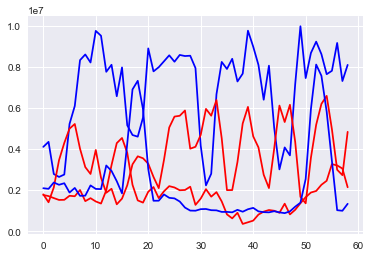

In [14]:
def _nwrmse(y_truth, y_pred, scaler_y):
    errors = []

    for i in range(y_truth.shape[0]):
        forecast_y_pred = scaler_y.inverse_transform(y_pred[i, :].ravel())
        forecast_y_truth = scaler_y.inverse_transform(y_truth[i, :].ravel())
        
        plt.plot(range(forecast_y_pred.shape[0]), forecast_y_pred, color='red')
        plt.plot(range(forecast_y_truth.shape[0]), forecast_y_truth, color='blue')
        
        
        count = forecast_y_pred.shape[0]
        weights = (3 * count - 2 * np.arange(1, count + 1) + 1) / (2 * count ** 2)
        error = np.sqrt(np.sum(((forecast_y_truth - forecast_y_pred) ** 2) * weights))
        mean_error = error / np.average(forecast_y_truth)
        errors.append(mean_error)

    return np.average(errors)

y_pred = model.predict(tx_test)
_nwrmse(ty_test, y_pred, scaler_y)

(59,)
(2, 1, 59)


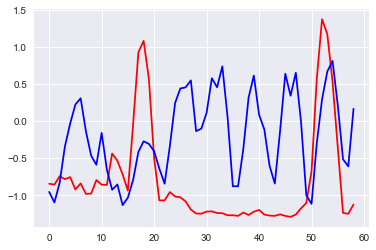

In [15]:
y_p = y_pred[-1, 0]
print(y_p.shape)
print(ty_test.shape)

plt.plot(np.arange(y_p.shape[0]), ty_test[-1, 0].ravel(), color='red')
plt.plot(np.arange(y_p.shape[0]), y_p, color='blue')